In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:0'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)
print(f'\nsignal mean={np.mean(signal)}')
M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST

SIGNUM = 2      
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M={M}')
print(f'minmax={MINMAX}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0

signal mean=-6.580979147873308e-17
Signal Length M=20000
minmax=1.611402028919085


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

def compute_rank(a, g, wr, wi, n, k):
    tols = [1/10**x for x in range(0,20)]
    x0 = np.zeros((n,1))
    u0 = np.zeros((k,1))
    A = rca.leaky_jacobian(x0, u0, a, g, wi, wr)
    B = rca.partial_u(x0, u0, a, g, wi, wr)
    Cn = rca.reachable_matrix(A,B)
    nan_flag = np.isnan(Cn).any()
    inf_flag = np.isinf(Cn).any()
    print(f'NaN present {nan_flag}\t inf present {inf_flag}\n')
    Cn = np.nan_to_num(rca.reachable_matrix(A,B), nan=1)
    if(SIGNUM != 3): # Square Cn
        Cn = Cn/np.abs(np.max(np.linalg.eigvals(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.abs(np.max(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank}')
    return ave_rank

In [3]:
min_a, max_a = .2,.8      # .2, .4
min_sr, max_sr = 5,6.5   # 5., 6.5
min_g, max_g = .2, .4     # .2, .4
min_ri, max_ri = .4, .7   # .001, 5.
min_rr, max_rr = 2, 3 # .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .25)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        Wr= Wres.detach().cpu().numpy()
        Wi= Win.detach().cpu().numpy()
        rank = compute_rank(a, amp, Wr, Wi, N, K)
        currentParams = np.array([a,sr,amp,ri,rr,loss,rank])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./MG_Saved_Models/MG_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Ref {ref} Run {rn} Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss



 ********** 300 ***********
Iter: 0 #### Diagnostic 1000.000   Time 7.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 6.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 61.056   Time 7.93  Best 1000.000 NRMSE 60.155 CD 0.901
Iter: 5 #### Diagnostic 1.019   Time 6.83  Best 1000.000 NRMSE 0.241 CD 0.777
Iter: 6 #### Diagnostic 245.899   Time 6.24  Best 1000.000 NRMSE 244.900 CD 0.999
Iter: 7 #### Diagnostic 1000.000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.743   Time 6.99  Best 1000.000 NRMSE 0.202 CD 0


Best result = 0.4598286589358626
a = 0.5579021210260929
sr = 5.057933946718343
amp = 0.3013569903721889
ri = 0.6430979375541773
rr = 2.192186840297491

 ********** 300 ***********
Iter: 0 #### Diagnostic 1000.000   Time 8.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 8.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.992   Time 6.33  Best 1000.000 NRMSE 0.241 CD 0.750
Iter: 7 #### Diagnostic 0.776   Time 6.14  Best 1000.000 NRMSE 0.210 CD 0.565
Iter: 8 #### Diagnostic 1000.000   Time 6.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1

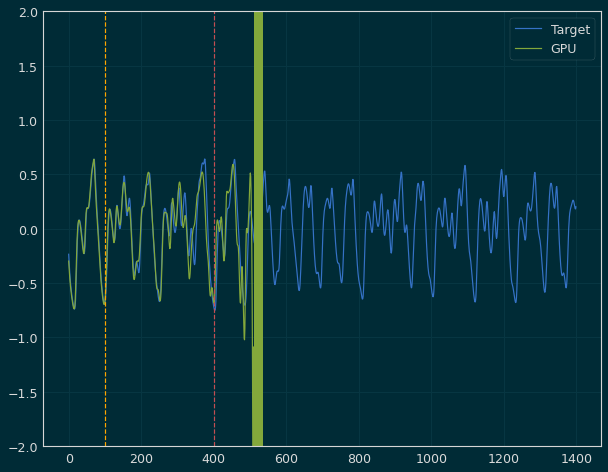

 Ref 0 Run 1 Iter=22 a=0.629 sr=5.132 amp=0.232  ri=0.602 rr=2.401 loss=0.168854


Iter: 22 #### Diagnostic 0.169   Time 9.52  Best 0.169 NRMSE 0.082 CD 0.087
Iter: 23 #### Diagnostic 1000.000   Time 6.83  Best 0.169 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 6.88  Best 0.169 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 5.88  Best 0.169 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 8.02  Best 0.169 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 6.05  Best 0.169 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 7.25  Best 0.169 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 7.19  Best 0.169 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 7.68  Best 0.169 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.023   Time 7.64  Best 0.169 NRMSE 0.273 CD 0.750
Iter: 32 #### Diagnostic 0.554   Time 6.57  Best 0.169 NRMSE 0.177 CD 0.377
Iter: 33 #### Diagnostic 1000.000   Time 6.45  Be

Iter: 22 #### Diagnostic 1000.000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 6.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 6.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 8.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.448   Time 6.57  Best 1000.000 NRMSE 0.155 CD 0.294
Iter: 33 #### Diagnostic 1000.000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34

Iter: 20 #### Diagnostic 0.326   Time 6.49  Best 1000.000 NRMSE 0.124 CD 0.202
Iter: 21 #### Diagnostic 1000.000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 8.95  Best 1000.000 NRMSE 390364768599580724508491776.000 CD 1.000
Iter: 25 #### Diagnostic 1000.000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.642   Time 8.42  Best 1000.000 NRMSE 0.186 CD 0.455
Iter: 27 #### Diagnostic 1000.000   Time 7.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.902   Time 6.24  Best 1000.000 NRMSE 0.228 CD 0.674
Iter: 30 #### Diagnostic 1000.000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 7.22  Best 1000.000 NRMSE 1000.00

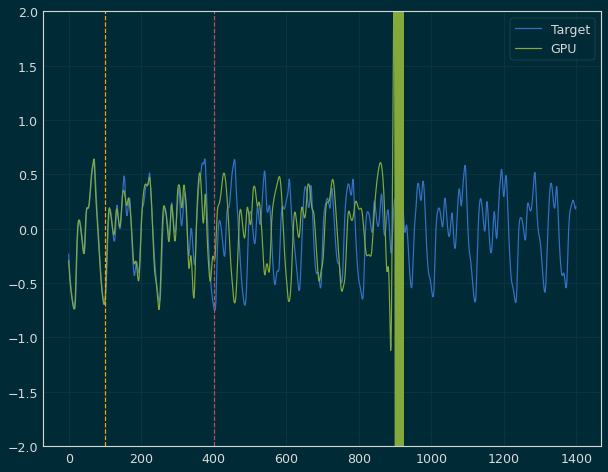

 Ref 0 Run 3 Iter=72 a=0.692 sr=6.013 amp=0.268  ri=0.604 rr=2.472 loss=0.188183


Iter: 72 #### Diagnostic 0.188   Time 9.68  Best 0.188 NRMSE 0.088 CD 0.100
Iter: 73 #### Diagnostic 1000.000   Time 6.21  Best 0.188 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 7.51  Best 0.188 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 8.60  Best 0.188 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 8.49  Best 0.188 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 6.33  Best 0.188 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.690   Time 7.72  Best 0.188 NRMSE 0.194 CD 0.495
Iter: 79 #### Diagnostic 1000.000   Time 6.34  Best 0.188 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 0.936   Time 7.55  Best 0.188 NRMSE 0.235 CD 0.701
Iter: 81 #### Diagnostic 1000.000   Time 6.63  Best 0.188 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.696   Time 7.37  Best 0.188 NRMSE 0.202 CD 0.494
Iter: 83 #### Diagnostic 1000.000   Time 8.13  Best 0

Iter: 70 #### Diagnostic 0.559   Time 8.01  Best 1000.000 NRMSE 0.172 CD 0.387
Iter: 71 #### Diagnostic 1000.000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 8.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.274   Time 6.70  Best 1000.000 NRMSE 0.291 CD 0.982
Iter: 78 #### Diagnostic 1000.000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 ###

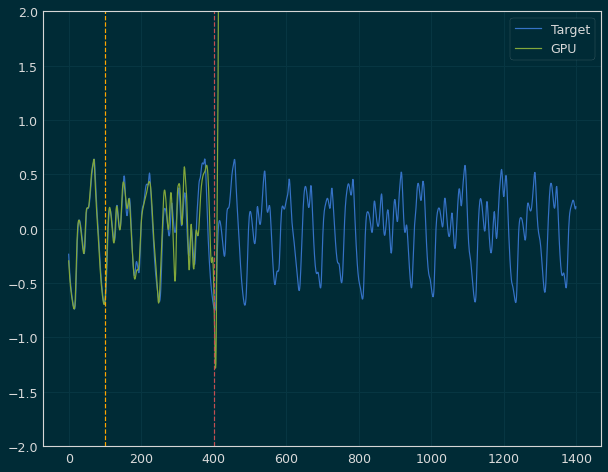

 Ref 1 Run 0 Iter=22 a=0.460 sr=5.785 amp=0.261  ri=0.677 rr=2.753 loss=0.223203


Iter: 22 #### Diagnostic 0.223   Time 8.24  Best 0.223 NRMSE 0.098 CD 0.125
Iter: 23 #### Diagnostic 1000.000   Time 7.55  Best 0.223 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 814.775   Time 8.54  Best 0.223 NRMSE 813.771 CD 1.003
Iter: 25 #### Diagnostic 1000.000   Time 6.61  Best 0.223 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 7.19  Best 0.223 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.895   Time 6.93  Best 0.223 NRMSE 0.361 CD 1.534
Iter: 28 #### Diagnostic 1000.000   Time 6.32  Best 0.223 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 6.74  Best 0.223 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.501   Time 8.87  Best 0.223 NRMSE 0.160 CD 0.341
Iter: 31 #### Diagnostic 1000.000   Time 6.91  Best 0.223 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.825   Time 7.46  Best 0.223 NRMSE 0.210 CD 0.615
Iter: 33 #### Diagnostic 1000.000   Time 8.34  Best 0

Iter: 22 #### Diagnostic 1000.000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.979   Time 7.20  Best 1000.000 NRMSE 0.242 CD 0.737
Iter: 30 #### Diagnostic 1000.000   Time 8.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.843   Time 8.55  Best 1000.000 NRMSE 0.366 CD 1.477
Iter: 33 #### Diagnostic 1000.000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 ###

Iter: 20 #### Diagnostic 1000.000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.788   Time 8.12  Best 1000.000 NRMSE 0.215 CD 0.573
Iter: 22 #### Diagnostic 1000.000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.144   Time 6.41  Best 1000.000 NRMSE 0.271 CD 0.873
Iter: 30 #### Diagnostic 1000.000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 6.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 ###

Iter: 18 #### Diagnostic 1000.000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.455   Time 7.35  Best 1000.000 NRMSE 0.145 CD 0.310
Iter: 21 #### Diagnostic 1000.000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.475   Time 6.74  Best 1000.000 NRMSE 0.155 CD 0.321
Iter: 25 #### Diagnostic 1000.000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 8.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 ###

Iter: 15 #### Diagnostic 1000.000   Time 8.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 22.726   Time 7.84  Best 1000.000 NRMSE 21.728 CD 0.997
Iter: 18 #### Diagnostic 1000.000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.094   Time 9.63  Best 1000.000 NRMSE 0.268 CD 0.826
Iter: 24 #### Diagnostic 1000.000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 6.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #

Iter: 5 #### Diagnostic 1000.000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 6.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 6.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 5.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.621   Time 6.25  Best 1000.000 NRMSE 0.190 CD 0.431
Iter: 16 #### Diagnostic 1000.000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 ####

Iter: 3 #### Diagnostic 1000.000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
NaN present False	 inf present False

Ave rank for N=300 is 53


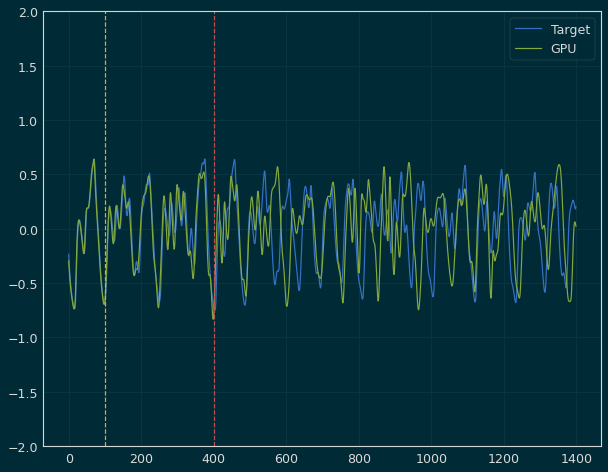

 Ref 2 Run 1 Iter=7 a=0.407 sr=5.443 amp=0.221  ri=0.679 rr=2.833 loss=0.154074


Iter: 7 #### Diagnostic 0.154   Time 7.06  Best 0.154 NRMSE 0.078 CD 0.076
Iter: 8 #### Diagnostic 1000.000   Time 6.56  Best 0.154 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 7.03  Best 0.154 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.21  Best 0.154 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 6.88  Best 0.154 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 6.36  Best 0.154 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 6.36  Best 0.154 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.927   Time 6.18  Best 0.154 NRMSE 0.238 CD 0.689
Iter: 15 #### Diagnostic 1000.000   Time 6.40  Best 0.154 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.173   Time 5.79  Best 0.154 NRMSE 0.254 CD 0.919
Iter: 17 #### Diagnostic 0.759   Time 6.04  Best 0.154 NRMSE 0.212 CD 0.546
Iter: 18 #### Diagnostic 1000.000   Time 5.77  Best 0.154

Iter: 7 #### Diagnostic 1000.000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 7.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.381   Time 5.54  Best 1000.000 NRMSE 0.136 CD 0.245
Iter: 16 #### Diagnostic 0.673   Time 5.67  Best 1000.000 NRMSE 0.196 CD 0.478
Iter: 17 #### Diagnostic 1000.000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### D

Iter: 4 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #

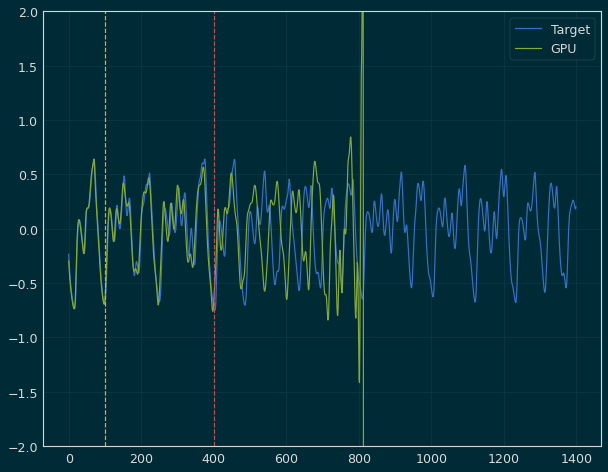

 Ref 2 Run 3 Iter=30 a=0.406 sr=5.904 amp=0.374  ri=0.678 rr=2.708 loss=0.137802


Iter: 30 #### Diagnostic 0.138   Time 7.20  Best 0.138 NRMSE 0.072 CD 0.066
Iter: 31 #### Diagnostic 1000.000   Time 6.10  Best 0.138 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.213   Time 7.39  Best 0.138 NRMSE 0.275 CD 0.937
Iter: 33 #### Diagnostic 1000.000   Time 5.46  Best 0.138 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 5.56  Best 0.138 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.747   Time 5.78  Best 0.138 NRMSE 0.204 CD 0.543
Iter: 36 #### Diagnostic 1000.000   Time 5.38  Best 0.138 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 42.203   Time 5.36  Best 0.138 NRMSE 41.132 CD 1.071
Iter: 38 #### Diagnostic 1000.000   Time 5.33  Best 0.138 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 0.639   Time 7.08  Best 0.138 NRMSE 0.186 CD 0.453
Iter: 40 #### Diagnostic 0.399   Time 7.37  Best 0.138 NRMSE 0.143 CD 0.256
Iter: 41 #### Diagnostic 1000.000   Time 6.55  Best 0.138 N

Iter: 30 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 13559956326811406386069504.000 CD 1.000
Iter: 31 #### Diagnostic 1000.000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.135   Time 5.33  Best 1000.000 NRMSE 0.274 CD 0.861
Iter: 35 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 80.981   Time 5.31  Best 1000.000 NRMSE 79.892 CD 1.089
Iter: 37 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 10

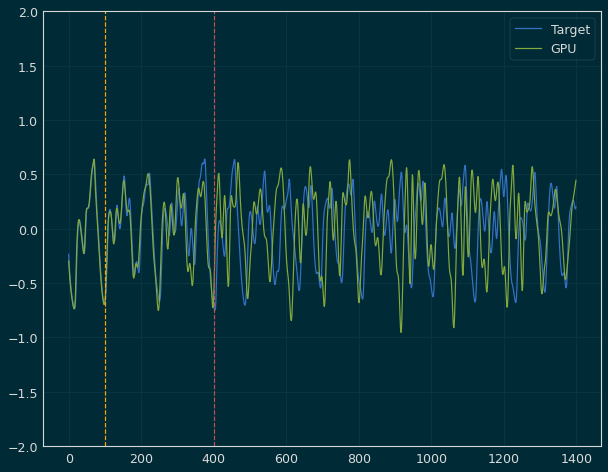

 Ref 2 Run 4 Iter=81 a=0.323 sr=6.086 amp=0.294  ri=0.517 rr=2.450 loss=0.203632


Iter: 81 #### Diagnostic 0.204   Time 6.23  Best 0.204 NRMSE 0.094 CD 0.110
Iter: 82 #### Diagnostic 1000.000   Time 5.33  Best 0.204 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 5.35  Best 0.204 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 0.607   Time 5.31  Best 0.204 NRMSE 0.185 CD 0.421
Iter: 85 #### Diagnostic 1000.000   Time 5.33  Best 0.204 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 5.34  Best 0.204 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 5.32  Best 0.204 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.068   Time 5.32  Best 0.204 NRMSE 0.247 CD 0.821
Iter: 89 #### Diagnostic 1000.000   Time 5.32  Best 0.204 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 5.32  Best 0.204 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.467   Time 5.32  Best 0.204 NRMSE 0.153 CD 0.314
Iter: 92 #### Diagnostic 1000.000   Time 5.33  Best 0

Iter: 71 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.448   Time 5.40  Best 1000.000 NRMSE 0.150 CD 0.297
Iter: 79 #### Diagnostic 0.347   Time 6.53  Best 1000.000 NRMSE 0.128 CD 0.219
Iter: 80 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.852   Time 5.42  Best 1000.000 NRMSE 0.212 CD 0.640
Iter: 82 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Di

Iter: 69 #### Diagnostic 1000.000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 138.830   Time 7.36  Best 1000.000 NRMSE 137.939 CD 0.891
Iter: 75 #### Diagnostic 1000.000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 66 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.925   Time 5.75  Best 1000.000 NRMSE 0.241 CD 0.683
Iter: 71 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 0.687   Time 5.33  Best 1000.000 NRMSE 0.202 CD 0.485
Iter: 77 #### Diagnostic 1000.000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 ###

Iter: 64 #### Diagnostic 0.349   Time 5.34  Best 1000.000 NRMSE 0.131 CD 0.218
Iter: 65 #### Diagnostic 0.784   Time 6.00  Best 1000.000 NRMSE 0.206 CD 0.578
Iter: 66 #### Diagnostic 1000.000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 0.870   Time 5.91  Best 1000.000 NRMSE 0.229 CD 0.640
Iter: 72 #### Diagnostic 1000.000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Di

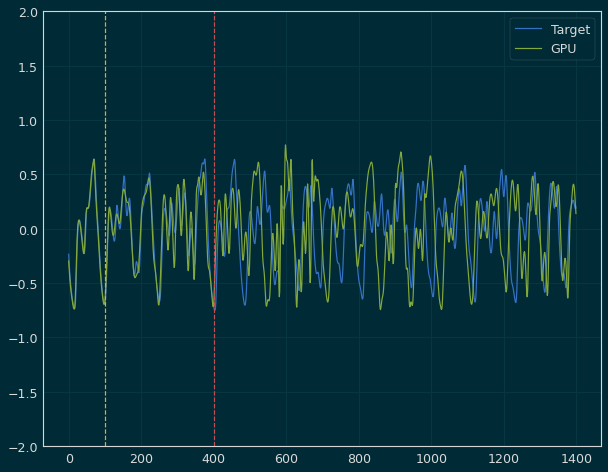

 Ref 3 Run 3 Iter=82 a=0.650 sr=5.344 amp=0.216  ri=0.538 rr=2.261 loss=0.161152


Iter: 82 #### Diagnostic 0.161   Time 6.51  Best 0.161 NRMSE 0.080 CD 0.081
Iter: 83 #### Diagnostic 1000.000   Time 5.89  Best 0.161 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 6.37  Best 0.161 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 5.34  Best 0.161 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 0.499   Time 6.79  Best 0.161 NRMSE 0.160 CD 0.339
Iter: 87 #### Diagnostic 1000.000   Time 7.38  Best 0.161 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 7.41  Best 0.161 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.247   Time 5.97  Best 0.161 NRMSE 0.108 CD 0.140
Iter: 90 #### Diagnostic 1000.000   Time 5.83  Best 0.161 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 7.42  Best 0.161 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.758   Time 7.37  Best 0.161 NRMSE 0.211 CD 0.547
Iter: 93 #### Diagnostic 1000.000   Time 7.16  Best 0

NaN present False	 inf present False

Ave rank for N=300 is 16


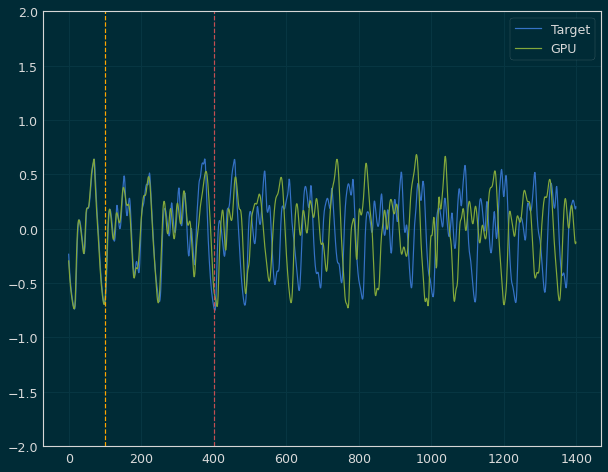

 Ref 3 Run 4 Iter=80 a=0.457 sr=5.075 amp=0.288  ri=0.654 rr=2.010 loss=0.222573


Iter: 80 #### Diagnostic 0.223   Time 6.26  Best 0.223 NRMSE 0.097 CD 0.126
Iter: 81 #### Diagnostic 1000.000   Time 5.33  Best 0.223 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 5.32  Best 0.223 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 5.33  Best 0.223 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 5.32  Best 0.223 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 5.34  Best 0.223 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 5.32  Best 0.223 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 5.32  Best 0.223 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 235.969   Time 5.32  Best 0.223 NRMSE 234.968 CD 1.001
Iter: 89 #### Diagnostic 1000.000   Time 5.33  Best 0.223 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 4.329   Time 5.32  Best 0.223 NRMSE 3.493 CD 0.836
Iter: 91 #### Diagnostic 1000.000   Time 5.38

Iter: 71 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 0.922   Time 5.32  Best 1000.000 NRMSE 0.231 CD 0.691
Iter: 77 #### Diagnostic 0.287   Time 5.34  Best 1000.000 NRMSE 0.116 CD 0.172
Iter: 78 #### Diagnostic 0.603   Time 5.35  Best 1000.000 NRMSE 0.180 CD 0.423
Iter: 79 #### Diagnostic 1000.000   Time 5.37  Best 1000.000 NRMSE 73843081538149839172665275884503040.000 CD 1.000
Iter: 80 #### Diagnostic 1000.000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.905   Time 5.38  Best 1000.000 NRMSE 0.223 CD 0.682
Iter: 82 #### Diagnostic 1000.000   Time 5.41  Best 1000.000 NRMSE 100

Iter: 69 #### Diagnostic 1000.000   Time 7.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 5.36  Best 1000.000 NRMSE 3913344752182828.500 CD 1.135
Iter: 78 #### Diagnostic 1000.000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.0

Iter: 66 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.839   Time 5.31  Best 1000.000 NRMSE 0.242 CD 0.597
Iter: 69 #### Diagnostic 0.767   Time 5.34  Best 1000.000 NRMSE 0.210 CD 0.557
Iter: 70 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 0.799   Time 5.32  Best 1000.000 NRMSE 0.209 CD 0.589
Iter: 73 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.241   Time 5.32  Best 1000.000 NRMSE 0.302 CD 0.939
Iter: 77 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagno

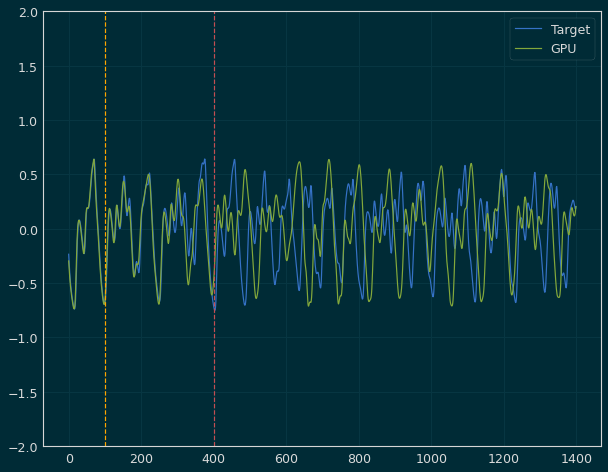

 Ref 4 Run 3 Iter=29 a=0.680 sr=5.464 amp=0.214  ri=0.587 rr=2.155 loss=0.220377


Iter: 29 #### Diagnostic 0.220   Time 6.24  Best 0.220 NRMSE 0.098 CD 0.123
Iter: 30 #### Diagnostic 1000.000   Time 5.32  Best 0.220 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 5.35  Best 0.220 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 5.33  Best 0.220 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 5.32  Best 0.220 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 5.34  Best 0.220 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 5.32  Best 0.220 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 5.33  Best 0.220 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 5.32  Best 0.220 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.861   Time 5.35  Best 0.220 NRMSE 0.224 CD 0.637
Iter: 39 #### Diagnostic 1000.000   Time 5.32  Best 0.220 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 5.32

Iter: 27 #### Diagnostic 0.618   Time 5.55  Best 1000.000 NRMSE 0.191 CD 0.428
Iter: 28 #### Diagnostic 1000.000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 3.160   Time 5.31  Best 1000.000 NRMSE 2.364 CD 0.796
Iter: 35 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.795   Time 5.31  Best 1000.000 NRMSE 0.218 CD 0.577
Iter: 39 #### Di

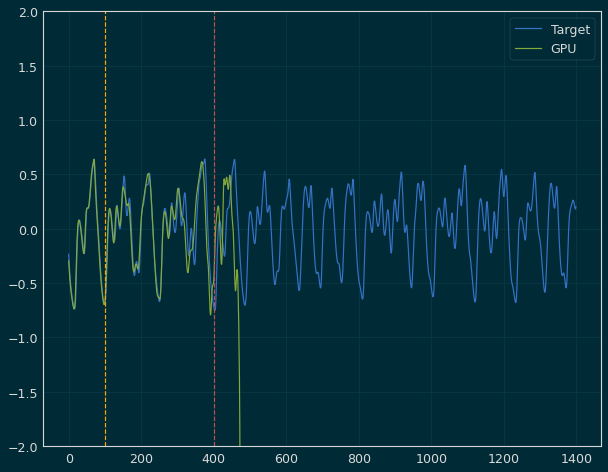

 Ref 4 Run 4 Iter=91 a=0.499 sr=6.412 amp=0.242  ri=0.673 rr=2.956 loss=0.185648


Iter: 91 #### Diagnostic 0.186   Time 8.39  Best 0.186 NRMSE 0.089 CD 0.097
Iter: 92 #### Diagnostic 1000.000   Time 5.36  Best 0.186 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 0.502   Time 5.30  Best 0.186 NRMSE 0.162 CD 0.340
Iter: 94 #### Diagnostic 1000.000   Time 5.31  Best 0.186 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.030   Time 5.31  Best 0.186 NRMSE 0.242 CD 0.788
Iter: 96 #### Diagnostic 1000.000   Time 5.31  Best 0.186 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 5.76  Best 0.186 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 5.42  Best 0.186 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.132   Time 5.92  Best 0.186 NRMSE 0.436 CD 0.695

Best result = 0.18564814866453533
a = 0.49899903144218594
sr = 6.4118799008768965
amp = 0.24223856223745915
ri = 0.6734859657709176
rr = 2.9558320803451297

Best mn:0.499	 mn:0.680
New bounds mn--mx: 0.040---0.05

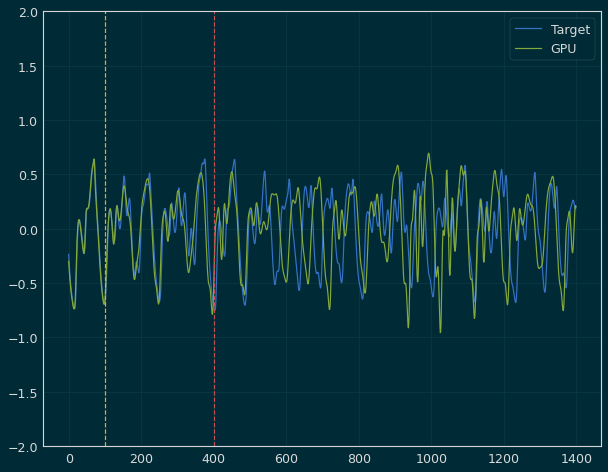

 Ref 0 Run 0 Iter=15 a=0.254 sr=5.436 amp=0.222  ri=0.442 rr=2.611 loss=0.247024


Iter: 15 #### Diagnostic 0.247   Time 5.71  Best 0.247 NRMSE 0.106 CD 0.141
Iter: 16 #### Diagnostic 1000.000   Time 5.19  Best 0.247 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.684   Time 5.12  Best 0.247 NRMSE 0.196 CD 0.489
Iter: 18 #### Diagnostic 1000.000   Time 5.09  Best 0.247 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.005   Time 5.11  Best 0.247 NRMSE 0.248 CD 0.757
Iter: 20 #### Diagnostic 1000.000   Time 5.10  Best 0.247 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.907   Time 5.09  Best 0.247 NRMSE 0.374 CD 1.534
Iter: 22 #### Diagnostic 0.843   Time 5.08  Best 0.247 NRMSE 0.235 CD 0.607
Iter: 23 #### Diagnostic 1000.000   Time 5.09  Best 0.247 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 5.09  Best 0.247 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 5.12  Best 0.247 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 5.09  Best 0.247

Iter: 15 #### Diagnostic 1000.000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.602   Time 5.12  Best 1000.000 NRMSE 0.179 CD 0.423
Iter: 23 #### Diagnostic 1000.000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
size = [300,200,100,50]

rand_state = [11,37,3,24,91,7,130]

for N in size:
    min_a, max_a = .2,.8      # .2, .4
    min_sr, max_sr = 5,6.5    # 5., 6.5
    min_g, max_g = .2, .4     # .2, .4
    min_ri, max_ri = .4, .7   # .001, 5.
    min_rr, max_rr = 2, 3     # .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')